# Chapter 5 Exercises

_(Applied)_

## Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
from matplotlib import gridspec

from tqdm.notebook import tqdm_notebook

import warnings
warnings.simplefilter('ignore')

plt.style.use('ggplot')

colors= [c['color'] for c in plt.rcParams['axes.prop_cycle']]

/Users/renierbotha/anaconda3/envs/data-science/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/Users/renierbotha/anaconda3/envs/data-science/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


## Question 5

_Skipping because it's on basics of validation splits, which I am comfortable with_

In [3]:
# Skipped

## Question 6

In [11]:
from sklearn.linear_model import LogisticRegression

default = pd.read_csv('../data/default.csv')

X = default[['income','balance']]
y, classes = default['default'].factorize()

X.head()

,income,balance
0,44361.625074,729.526495
1,12106.134700,817.180407
2,31767.138947,1073.549164
3,35704.493935,529.250605
4,38463.495879,785.655883


In [6]:
sm_model = sm.Logit(y, sm.add_constant(X)).fit(disp=0)
sm_model.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.459      
Dependent Variable: y                AIC:              1584.9663  
Date:               2020-04-22 15:28 BIC:              1606.5973  
No. Observations:   10000            Log-Likelihood:   -789.48    
Df Model:           2                LL-Null:          -1460.3    
Df Residuals:       9997             LLR p-value:      4.5409e-292
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     10.0000                                       
-------------------------------------------------------------------
            Coef.    Std.Err.     z      P>|z|    [0.025    0.975] 
-------------------------------------------------------------------
const      -11.5405    0.4348  -26.5437  0.0000  -12.3926  -10.6883
income       0.0000    0.0000    4.1741  0.0000    0.0000    0.0000
balance      0.0056    0.0002   24.8354  0.0000    0.0052    0.0061
==================================================================

"""

In [20]:
lr = LogisticRegression()
lr.fit(X, y)

print('Coefficients:')
lr.coef_

Coefficients:


array([[2.08091985e-05, 5.64710797e-03]])

In [16]:
def boot(data, idx_list):
    
    data = data.iloc[idx_list]
    
    X = data[['income','balance']]
    y, classes = data['default'].factorize()

    
    lr = LogisticRegression()
    lr.fit(X, y)
    
    return lr.coef_

In [18]:
N = 1000
coefs = np.zeros((N, 2))
for i in tqdm_notebook(range(N)):
    idx_list = np.random.choice(range(default.shape[0]), size=default.shape[0])
    
    coefs[i,:] = boot(default, idx_list)
    

(array([-5.89064871e-05,  2.52185187e-03]),
 array([7.56926153e-05, 2.77104505e-03]))

In [23]:
print('Bootstrap SE:')
print(' - Income:',coefs[:,0].std())
print(' - Balance:', coefs[:,1].std())

print('\n\nStatsmodels SE:')
display(sm_model.params.drop('const'))

Bootstrap SE:
 - Income: 7.569261525671051e-05
 - Balance: 0.0027710450493156446


Statsmodels SE:


income     0.000021
balance    0.005647
dtype: float64

**Insight**

The bootstrap and statsmodels standard errors are the same orders of magnitude, but are slightly off. This is expected, as it's a stochastic process and dependent on initial seeds and size of bootstrap samples. 

## Question 7

_Only doing the LOOCV computation. The rest is just basics_

In [24]:
weekly = pd.read_csv('../data/weekly.csv')
weekly.head()

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction
0,1990,0.816,1.572,-3.936,-0.229,-3.484,0.154976,-0.270,Down
1,1990,-0.270,0.816,1.572,-3.936,-0.229,0.148574,-2.576,Down
2,1990,-2.576,-0.270,0.816,1.572,-3.936,0.159837,3.514,Up
3,1990,3.514,-2.576,-0.270,0.816,1.572,0.161630,0.712,Up
4,1990,0.712,3.514,-2.576,-0.270,0.816,0.153728,1.178,Up


In [39]:
errors = []
for i in tqdm_notebook(range(weekly.shape[0])):
    
    tr_data = weekly.drop(i)
    val_data = weekly.loc[i]
    
    X = weekly[['Lag1','Lag2']]
    y = weekly.Direction.replace({'Down': 0, 'Up': 1})
    
    X_train, y_train = X.drop(i), y.drop(i)
    X_val, y_val = X.loc[i], y.loc[i]
    
    X_val = X_val.values.reshape(1,-1)
    
    lr = LogisticRegression()
    lr.fit(X_train, y_train)
    
    pred = lr.predict(X_val)[0]
    
    # 1 if incorrect
    error = int(pred != y_val)

    errors.append(error)
    


In [41]:
print('LOOCV Error Rate: ',np.mean(errors))

LOOCV Error Rate:  0.44995408631772266


**Insight**

Yeah, not that great. 

## Question 8

In [159]:
np.random.seed(1)

x = np.random.randn(100)
y = x - 2*x**2 + np.random.randn(100)

data = pd.DataFrame(np.c_[x,y], columns=['X','y'])

data['X2'] = data['X']**2
data['X3'] = data['X']**3
data['X4'] = data['X']**4


data.head()

,X,y,X2,X3,X4
0,1.624345,-4.099779,2.638498,4.285832,6.961671
1,-0.611756,-0.135741,0.374246,-0.228947,0.140060
2,-0.528172,-0.682611,0.278965,-0.147342,0.077822
3,-1.072969,-2.781913,1.151262,-1.235268,1.325403
4,0.865408,-1.727365,0.748930,0.648130,0.560897


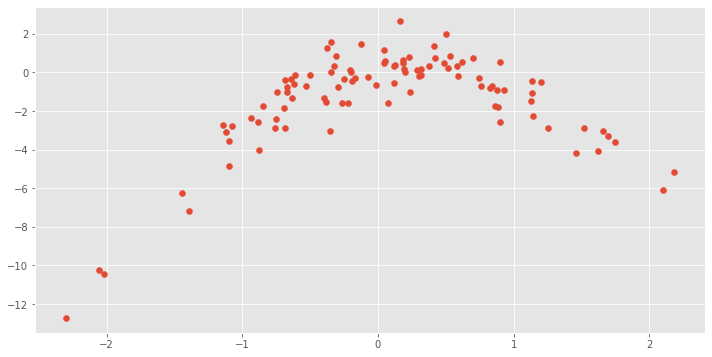

In [160]:
plt.figure(figsize=(12,6))
plt.scatter(x, y)

### Using sklearn

In [161]:
from sklearn.linear_model import LinearRegression

def loocv(X, y):
    errors = []
    for i in tqdm_notebook(range(X.shape[0])):
        
        X_train, y_train = X.drop(i), y.drop(i)
        X_val, y_val = X.loc[i], y.loc[i]

        X_val = X_val.values.reshape(1,-1)

        lr = LinearRegression()
        lr.fit(X_train, y_train)

        pred = lr.predict(X_val)[0]

        error = (pred - y_val)**2

        errors.append(error)
        
    return errors
    
    

for pol in [1,2,3,4]:
    
    if pol == 1:
        X = data[['X']]
    else:
        X = data[['X'] + [f'X{i}' for i in range(2, pol+1)]]
        
    y = data['y']
        
    errors = loocv(X, y)
    
    print('Features:',X.columns.tolist())
    print('\tLOOCV Error: {:.3f} ± {:.4f}'.format(np.mean(errors), np.std(errors)))



Features: ['X']
	LOOCV Error: 6.261 ± 14.2550



Features: ['X', 'X2']
	LOOCV Error: 0.914 ± 1.3419



Features: ['X', 'X2', 'X3']
	LOOCV Error: 0.927 ± 1.3496



Features: ['X', 'X2', 'X3', 'X4']
	LOOCV Error: 0.867 ± 1.2414


### Using statsmodels

In [108]:
eqs = [
    'y ~ X',
    'y ~ X + np.power(X, 2)',
    'y ~ X + np.power(X, 2) + np.power(X,3)',
    'y ~ X + np.power(X, 2) + np.power(X,3) + np.power(X,4)',
]

errors_eq = {}

for eq in eqs:
    errors = []
    for i in tqdm_notebook(range(data.shape[0])):

        tr_data = data.drop(i)
        val_data = data.loc[i]

        y_val = val_data['y']

        model = smf.ols(eq, data=tr_data).fit()

        pred = model.predict(val_data).values[0]

        error = (pred - y_val)**2

        errors.append(error)
        
    print('LOOCV Error: {:.3f} ± {:.4f}\t--\t{}'.format(np.mean(errors), np.std(errors), eq))
    
    errors_eq[eq] = errors


LOOCV Error: 0.132 ± 0.1453	--	y ~ X



LOOCV Error: 0.106 ± 0.0805	--	y ~ X + np.power(X, 2)



LOOCV Error: 0.107 ± 0.0820	--	y ~ X + np.power(X, 2) + np.power(X,3)



LOOCV Error: 0.109 ± 0.0860	--	y ~ X + np.power(X, 2) + np.power(X,3) + np.power(X,4)


**Insight**

Lowest LOOCV Error (MSE) is `0.106 ± 0.0805` with `y ~ X + X^2`.

This makes sense, because we know that `y` is a 2nd order polynomial function of `X`.

## Question 9



In [152]:
boston = pd.read_csv('../data/boston.csv')
boston.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


In [187]:
# a
mu = boston.medv.mean()
print('Population mean = ',mu)

# b
print('Standard error = ',boston.medv.std() / np.sqrt(boston.shape[0]))

Population mean =  22.532806324110677
Standard error =  0.40886114749753505


In [192]:
# c
def boot_sample(x, stat, n_boot=1000, n_s=None, **kwargs):
    if not n_s:
        n_s = len(x)
    bootstraps = []
    for _ in range(n_boot):
        sample = np.random.choice(x, size=n_s, replace=True)
        bootstraps.append(eval(f'np.{stat}')(sample, **kwargs))
    return bootstraps

bs_samples = boot_sample(boston.medv, 'mean')

# Standard deviation of the mean distribution is equal to the standard error
print('Bootstrap SE:',np.std(bs_samples))

Bootstrap SE: 0.4041950303697156


Close to the SE of the population sample

In [184]:
boston.shape

(506, 14)

**How does this change with bootstrap sample size?**

_Not the number of bootstrap samples, but the size of each bootstrap sample._

In [186]:
for n_s in range(100, 2000, 200):
    bs_samples = boot_sample(boston.medv, 'mean',n_s=n_s)
    print(n_s,' Bootstrap SE:',np.std(bs_samples))

100  Bootstrap SE: 0.9063359021554865
300  Bootstrap SE: 0.5495016022743802
500  Bootstrap SE: 0.40790327866081194
700  Bootstrap SE: 0.3480725648115781
900  Bootstrap SE: 0.30772253589151716
1100  Bootstrap SE: 0.27826923551477123
1300  Bootstrap SE: 0.25508726693789757
1500  Bootstrap SE: 0.23583120347471698
1700  Bootstrap SE: 0.22072058192146676
1900  Bootstrap SE: 0.2097681530686397


As the number of bootstrap samples approaches the true sample size, the SE approaches the population SE. 

However, because SE always decreases with number of samples, increasing the sample size decreases the SE beyond the true value.

In [189]:
# d
bs_samples = boot_sample(boston.medv, 'mean')
bs_se = np.std(bs_samples)

print('95% Confidence Interval: [{:.2f}, {:.2f}]'.format(mu-2*bs_se, mu+2*bs_se))

95% Confidence Interval: [21.72, 23.34]


**Using Facebook's `bootstrapped` library**

In [123]:
import bootstrapped.bootstrap as bs
import bootstrapped.stats_functions as bs_stats

In [155]:
bs.bootstrap(boston.medv.values, stat_func=bs_stats.mean)

22.532806324110677    (21.715607707509893, 23.32451581027669)

We get the same results

In [190]:
# e
median = boston.medv.median()
print('Median = ',median)

Median =  21.2


In [191]:
# f
bs_samples = boot_sample(boston.medv, 'median')
bs_se = np.std(bs_samples)

print('SE of median:',bs_se)

SE of median: 0.3751129829797947


In [193]:
# g
q10 = np.quantile(boston.medv, 0.1)
print('Q10 = ',q10)

Q10 =  12.75


In [194]:
# h
bs_samples = boot_sample(boston.medv, 'quantile', q=0.1)
bs_se = np.std(bs_samples)
print('SE of Q10:',bs_se)

SE of Q10: 0.4918068726644637
